In [1]:
using ModelingToolkit, ThermalSystem_Models, Logging, Revise, CoolProp, Printf, OrdinaryDiffEq, Plots
gr()

Revise.retry()
Logging.disable_logging(Logging.Warn)

TSM = ThermalSystem_Models
TSMD = TSM.Dynamics
TSMT = TSM.DeadTime
MTK = ModelingToolkit
Steam = TSMD.Steam
Gas = TSMD.Gas
Liq = TSMD.Liq

ThermalSystem_Models.Dynamics.Liq

## Heat Exchangers

In [ ]:
# Liquid to gas
@component function L2G_HeatExchanger(;name, ϵ = 0.95)
    @named A = Gas.ThermoHeatTransfer()
    @named B = Liq.IncompressibleHeaatTransfer()

    ps = @parameters ϵ = ϵ

    @variables Q̇(t)=0.0 Cmin(t)=0.0
    
    eqs = [
        Q̇ ~ ϵ * (A.p.T - B.p.T) * ((A.C < B.C) *  A.C + (A.C >= B.C) * B.C)      #   heat transfer out of A -> B , if A/T > B/T 
        0 ~ A.Q̇ + B.Q̇
        A.Q̇ ~ -Q̇
    ]

    ODESystem(eqs, t, [Q̇], ps; name = name, systems = [A,B], defaults = [ϵ => 0.95] )
end

@component function S2G_HeatExchanger(;name, ϵ = 0.95)
    @named A = Gas.ThermoHeatTransfer()
    @named B = Steam.SteamHeatTransfer()

    # A = substitute(A, Gas.propDict)
    # B = substitute(B, Steam.hydro_prop_dict)
    ps = @parameters ϵ = ϵ

    @variables Q̇(t)=0.0 Cmin(t)=0.0
    
    eqs = [
        Q̇ ~ ϵ * (A.p.T - B.p.T) * ((A.C < B.C) *  A.C + (A.C >= B.C) * B.C)      #   heat transfer out of A -> B , if A/T > B/T 
        0 ~ A.Q̇ + B.Q̇
        A.Q̇ ~ -Q̇
    ]
    ODESystem(eqs, t, [Q̇], ps; name = name, systems = [A,B], defaults = [ϵ => 0.95] )
end

@component function L2S_HeatExchanger(;name, ϵ = 0.95)
    @named A = Liq.IncompressibleHeaatTransfer()
    @named B = Steam.SteamHeatTransfer()

    # A = substitute(A, Gas.propDict)
    # B = substitute(B, Steam.hydro_prop_dict)
    ps = @parameters ϵ = ϵ

    @variables Q̇(t)=0.0 Cmin(t)=0.0
    
    eqs = [
        Q̇ ~ ϵ * (A.p.T - B.p.T) * ((A.C < B.C) *  A.C + (A.C >= B.C) * B.C)      #   heat transfer out of A -> B , if A/T > B/T 
        0 ~ A.Q̇ + B.Q̇
        A.Q̇ ~ -Q̇
    ]
    ODESystem(eqs, t, [Q̇], ps; name = name, systems = [A,B], defaults = [ϵ => 0.95] )
end


### Gas 2 liquid xh

In [ ]:
@named StmRes   = Steam.Reservoir(P = 40)
@named StmValve = Steam.SteamFlowSource(ṁ = 10)

@named HeRes   = Gas.SinglePortReservoir(P = 10, T = 800)  
@named HeValve = Gas.GasFlowSource(Ṁ = 70)

@named hx = S2G_HeatExchanger()

# steam connectinos
connections = vcat(Steam.hydro_connect(StmRes.n,StmValve.p),
                Steam.hydro_connect(StmValve.n,hx.B.p),
                Gas.gas_connect(HeRes.n,HeValve.p),
                Gas.gas_connect(HeValve.n, hx.A.p))

@named SysS = ODESystem(connections,t; name = :SysS, systems = [HeRes,HeValve,StmRes,StmValve,hx])
SysS = substitute(SysS, Gas.propDict)
SysS = substitute(SysS, Steam.hydro_prop_dict)

# @named StmSys = ODESystem(steamconn,t; systems =[StmRes,StmValve,hx.B])
# StmSys = substitute(StmSys,Steam.hydro_prop_dict)
# @named sys = compose(StmSys,GasSys,hx)

simple_mod = structural_simplify(SysS)
# equations(hx)
prob = ODAEProblem(simple_mod,Pair[],(0.0,1.0))

sol = solve(prob)

# Steam.hydro_prop_dict
equations(SysS)

@show sol[hx.B.C]
@show sol[hx.B.p.T]-sol[hx.B.n.T]
@show sol[hx.A.p.T]-sol[hx.A.n.T]
@show sol[hx.A.n.T]

Gas.showsol([HeRes,HeValve,hx.A,hx.B,StmRes,StmValve],sol)


### Gas to incompressible liquid

In [ ]:
@named LiqRes   = Liq.SinglePortReservoir(P = 40, T =700)
@named LiqValve = Liq.IncompressibleFixedFlowSource(Ṁ = 120)

@named HeRes    = Gas.SinglePortReservoir(P = 10, T = 300)  
@named HeValve  = Gas.GasFlowSource(Ṁ = 10)

@named hx = L2G_HeatExchanger()

# steam connectinos
connections = vcat(Liq.incompressible_connect(LiqRes.n, LiqValve.p),  
                Liq.incompressible_connect(LiqValve.n,hx.B.p),
                Gas.gas_connect(HeRes.n, HeValve.p),
                Gas.gas_connect(HeValve.n, hx.A.p))

@named SysS = ODESystem(connections,t; name = :SysS, 
                    systems = [HeRes,HeValve,LiqRes,LiqValve,hx])
SysS = substitute(SysS, Gas.propDict)
SysS = substitute(SysS, Liq.propDict)


simple_mod = structural_simplify(SysS)
prob = ODAEProblem(simple_mod,Pair[],(0.0,1.0))

sol = solve(prob)
@show sol[hx.B.C]
@show sol[hx.B.p.T]-sol[hx.B.n.T]
@show sol[hx.A.p.T]-sol[hx.A.n.T]
@show sol[hx.A.n.T]

Gas.showsol([HeRes,HeValve,hx.A,hx.B,LiqRes,LiqValve],sol)




### Liquid to Steam

In [ ]:
@named LiqRes   = Liq.SinglePortReservoir(P = 40, T =900)
@named LiqValve = Liq.IncompressibleFixedFlowSource(Ṁ = 100)

@named StmRes   = Steam.Reservoir(P = 80)
@named StmValve = Steam.SteamFlowSource(ṁ = 5)

@named hx = L2S_HeatExchanger()

# steam connectinos
connections = vcat(Liq.incompressible_connect(LiqRes.n, LiqValve.p),  
                Liq.incompressible_connect(LiqValve.n,hx.A.p),
                Steam.hydro_connect(StmRes.n, StmValve.p),
                Steam.hydro_connect(StmValve.n, hx.B.p))

@named SysS = ODESystem(connections,t; name = :SysS, 
                    systems = [StmRes,StmValve,LiqRes,LiqValve,hx])

SysS = substitute(SysS, Steam.hydro_prop_dict)
SysS = substitute(SysS, Liq.propDict)


simple_mod = structural_simplify(SysS)
prob = ODAEProblem(simple_mod,Pair[],(0.0,1.0))

sol = solve(prob)
@show sol[hx.B.C]
@show sol[hx.B.p.T]-sol[hx.B.n.T]
@show sol[hx.A.p.T]-sol[hx.A.n.T]
@show sol[hx.A.n.T]

Gas.showsol([StmRes,StmValve,hx.A,hx.B,LiqRes,LiqValve],sol)

@show sol[LiqValve.p.cp]
@show sol[StmRes.n.x]
@show sol[StmValve.p.x]
@show sol[hx.B.n.x]

## Rankine Cycles

### Simple Rankine

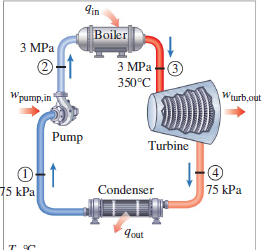

In [35]:
@named WorkRes     = Steam.WorkPin()
@named ColdUtil    = Steam.HeatTransferPin()
@named HotUtil     = Steam.HeatTransferPin()
@variables t
sysnames(x) = display([s.name for s in x.systems])
Tmax = 350+273.15;
Pmax = 30;  #   Bar
Pmin = 0.75; #   Bar

@named reservoir   = Steam.TwoPortReservoir(P=Pmin)
@named valve      = Steam.SteamFlowSource(ṁ = 1.0)
@named pump       = Steam.AdiabaticPump(Pout = Pmax, setpressure =true)
@named boiler     = Steam.IdealBoiler(Tout = Tmax)
@named turbine    = Steam.AdiabaticTurbine(setpressure = true, Pout = Pmin)
@named condensor  = Steam.PassiveCondensor()

systems = [reservoir, valve, pump, boiler, turbine, condensor, WorkRes, ColdUtil, HotUtil];
connections = vcat(Steam.hydro_connect(reservoir.n,valve.p),
                    Steam.hydro_connect(valve.n,pump.p),
                    Steam.hydro_connect(pump.n, boiler.p),
                    Steam.hydro_connect(boiler.n, turbine.p),
                    Steam.hydro_connect(turbine.n, condensor.p),
                    Steam.hydro_connect(condensor.n, reservoir.p),
                    TSMD.work_connect(WorkRes, turbine.w, pump.w),
                    TSMD.heat_connect(ColdUtil, condensor.q),
                    TSMD.heat_connect(HotUtil, boiler.q));
         
@named ODESYS = ODESystem(connections, t; systems = systems)
TSMD.system_details(ODESYS)
simple_sys = structural_simplify(ODESYS)
tspan = (0.0,1.0)
ode_prob = ODEProblem(simple_sys,[],tspan,[0.75,1.0,1.0,30,Tmax,0.75,1.0])
sol = solve(ode_prob)
TSMD.showsol([reservoir, valve, pump, boiler, turbine, condensor, WorkRes, ColdUtil, HotUtil],sol)


************ SYSTEM: ODESYS ************
SYSTEM: ODESYS 
	 # of equations = 106
	 # of states = 105
	 # of parameters = 7
After Alias Elemination:
	 # of equations = 64
	 # of states = 64
	 # of parameters = 7


reservoir₊p    P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= +1.00  Φ=+0.00  h[kJ/kg]= 384.4   x= 0.00 
reservoir₊n    P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= -1.00  Φ=+0.00  h[kJ/kg]= 384.4   x= 0.00 
valve₊p        P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= +1.00  Φ=+0.00  h[kJ/kg]= 384.4   x= 0.00 
valve₊n        P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= -1.00  Φ=+0.00  h[kJ/kg]= 384.4   x= 0.00 
pump₊p         P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= +1.00  Φ=+0.00  h[kJ/kg]= 384.4   x= 0.00 Ẇ[kW]= -3.03   
pump₊n         P[bar]= 30.0     T[K]= 365.1   ṁ[kg/s]= -1.00  Φ=-0.00  h[kJ/kg]= 387.4   x= 0.00 Ẇ[kW]= -3.03   
boiler₊p       P[bar]= 30.0     T[K]= 365.1   ṁ[kg/s]= +1.00  Φ=+0.00  h[kJ/kg]= 387.4   x= 0.00 Q̇[kW]= 2728.66 


boiler₊n       P[bar]= 30.0     T[K]= 623.1   ṁ[kg/s]= -1.00  Φ=+2.73  h[kJ/kg]= 3116.1  x= 1.00 Q̇[kW]= 2728.66 
turbine₊p      P[bar]= 30.0     T[K]= 623.1   ṁ[kg/s]= +1.00  Φ=-2.73  h[kJ/kg]= 3116.1  x= 1.00 Ẇ[kW]= 713.03  
turbine₊n      P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= -1.00  Φ=+3.44  h[kJ/kg]= 2403.0  x= 0.89 Ẇ[kW]= 713.03  
condensor₊p    P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= +1.00  Φ=-3.44  h[kJ/kg]= 2403.0  x= 0.89 Q̇[kW]= -2018.66
condensor₊n    P[bar]= 0.8      T[K]= 364.9   ṁ[kg/s]= -1.00  Φ=+0.00  h[kJ/kg]= 384.4   x= 0.00 Q̇[kW]= -2018.66

WorkRes 	 Ẇ [kW] = -710.00
ColdUtil	 Q̇ [kW] = 2018.66
HotUtil 	 Q̇ [kW] = -2728.66



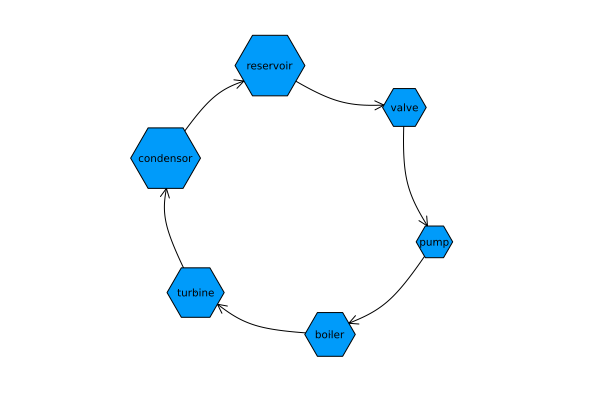

In [47]:
using Graphs, GraphRecipes, Plots
g,cdict,vdict = TSMD.system2graph(ODESYS);
graphplot(g,names = [vdict[i] for i =1:nv(g)])

### OPENFW

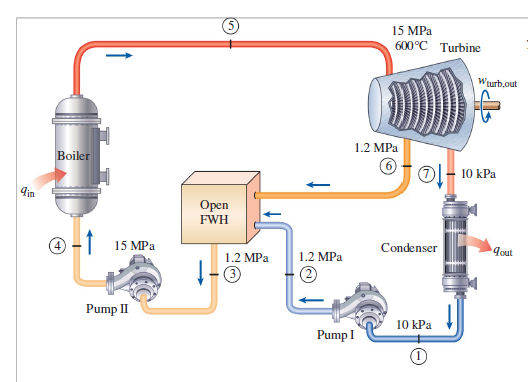

In [55]:
Pmid = 12
Pmin = 0.1
Pmax = 150
Tmax = 600+273.15
@named reservoir    = Steam.ContinuityReservoir()
@named valve        = Steam.SteamFlowSource(ṁ = 1.0)
@named pumpB        = Steam.AdiabaticPump(Pout = Pmax,setpressure = true, η=1.0)
@named boil         = Steam.IdealBoiler(Tout = Tmax)
@named turbine      = Steam.SIMOAdiabaticTurbine(setpressure = true, Pyin = Pmid, Pzin = Pmin,ηin = 1.0) 
@named pumpA        = Steam.AdiabaticPump(Pout = Pmid, setpressure = false, η=1.0)
@named condensor    = Steam.IdealCondensor()
# @named pset = Steam.setpressure()
@named openfw       = Steam.OpenFeedwaterHeater()

connections = vcat(Steam.hydro_connect(reservoir.n,valve.p),
                    Steam.hydro_connect(valve.n, boil.p),
                    Steam.hydro_connect(boil.n, turbine.p),
                    Steam.hydro_connect(turbine.hp.n, openfw.p1),
                    Steam.hydro_connect(turbine.lp.n, condensor.p),
                    Steam.hydro_connect(condensor.n, pumpA.p),
                    Steam.hydro_connect(pumpA.n,openfw.p2),
                    Steam.hydro_connect(openfw.n,pumpB.p),
                    Steam.hydro_connect(pumpB.n,reservoir.p))

systems = [valve,boil,turbine,pumpA,condensor,openfw,pumpB, reservoir]
@named ODESYS = ODESystem(connections, t; systems = systems)
TSMD.system_details(ODESYS)
simple_sys = structural_simplify(ODESYS)
tspan = (0.0,1.0)
ode_prob = ODEProblem(simple_sys,[],tspan,[1.0,Tmax,Pmid,Pmin,1.0,Pmid,1.0,Pmin,1.0,1.0,Pmid,1.0,Pmax])
sol = solve(ode_prob)
systems = [valve,boil,turbine.hp,turbine.lp,pumpA,condensor,openfw,pumpB, reservoir]
TSMD.showsol(systems,sol)


************ SYSTEM: ODESYS ************
SYSTEM: ODESYS 
	 # of equations = 187
	 # of states = 187
	 # of parameters = 13
After Alias Elemination:
	 # of equations = 113
	 # of states = 113
	 # of parameters = 13


valve₊p        P[bar]= 150.0    T[K]= 463.2   ṁ[kg/s]= +1.00  Φ=+0.00  h[kJ/kg]= 814.2   x= 0.00 
valve₊n        P[bar]= 150.0    T[K]= 463.2   ṁ[kg/s]= -1.00  Φ=+0.00  h[kJ/kg]= 814.2   x= 0.00 
boil₊p         P[bar]= 150.0    T[K]= 463.2   ṁ[kg/s]= +1.00  Φ=+0.00  h[kJ/kg]= 814.2   x= 0.00 Q̇[kW]= 2769.10 
boil₊n         P[bar]= 150.0    T[K]= 873.2   ṁ[kg/s]= -1.00  Φ=+2.77  h[kJ/kg]= 3583.3  x= 1.00 Q̇[kW]= 2769.10 


turbine₊hp₊p   P[bar]= 150.0    T[K]= 873.2   ṁ[kg/s]= +0.23  Φ=-2.77  h[kJ/kg]= 3583.3  x= 1.00 Ẇ[kW]= 164.54  
turbine₊hp₊n   P[bar]= 12.0     T[K]= 490.3   ṁ[kg/s]= -0.23  Φ=+2.93  h[kJ/kg]= 2858.9  x= 1.00 Ẇ[kW]= 164.54  
turbine₊lp₊p   P[bar]= 150.0    T[K]= 873.2   ṁ[kg/s]= +0.77  Φ=+0.00  h[kJ/kg]= 3583.3  x= 1.00 Ẇ[kW]= 1134.59 


turbine₊lp₊n   P[bar]= 0.1      T[K]= 319.0   ṁ[kg/s]= -0.77  Φ=+1.13  h[kJ/kg]= 2115.3  x= 0.80 Ẇ[kW]= 1134.59 
pumpA₊p        P[bar]= 0.1      T[K]= 319.0   ṁ[kg/s]= +0.77  Φ=+0.35  h[kJ/kg]= 191.8   x= 0.00 Ẇ[kW]= -0.93   
pumpA₊n        P[bar]= 12.0     T[K]= 319.0   ṁ[kg/s]= -0.77  Φ=-0.35  h[kJ/kg]= 193.0   x= 0.00 Ẇ[kW]= -0.93   
condensor₊p    P[bar]= 0.1      T[K]= 319.0   ṁ[kg/s]= +0.77  Φ=-1.13  h[kJ/kg]= 2115.3  

x= 0.80 Q̇[kW]= -1486.61
condensor₊n    P[bar]= 0.1      T[K]= 319.0   ṁ[kg/s]= -0.77  Φ=-0.35  h[kJ/kg]= 191.8   x= 0.00 Q̇[kW]= -1486.61
openfw₊n       P[bar]= 12.0     T[K]= 461.1   ṁ[kg/s]= -1.00  Φ=+2.58  h[kJ/kg]= 798.5   x= 0.00 y= 0.23    
openfw₊p1      P[bar]= 12.0     T[K]= 490.3   ṁ[kg/s]= +0.23  Φ=-2.93  h[kJ/kg]= 2858.9  x= 1.00 y= 0.23    


openfw₊p2      P[bar]= 12.0     T[K]= 319.0   ṁ[kg/s]= +0.77  Φ=+0.35  h[kJ/kg]= 193.0   x= 0.00 y= 0.23    
pumpB₊p        P[bar]= 12.0     T[K]= 461.1   ṁ[kg/s]= +1.00  Φ=-2.58  h[kJ/kg]= 798.5   x= 0.00 Ẇ[kW]= -15.71  
pumpB₊n        P[bar]= 150.0    T[K]= 463.2   ṁ[kg/s]= -1.00  Φ=+2.56  h[kJ/kg]= 814.2   x= 0.00 Ẇ[kW]= -15.71  


reservoir₊p    P[bar]= 150.0    T[K]= 463.2   ṁ[kg/s]= +1.00  Φ=-2.56  h[kJ/kg]= 814.2   x= 0.00 
reservoir₊n    P[bar]= 150.0    T[K]= 463.2   ṁ[kg/s]= -1.00  Φ=+0.00  h[kJ/kg]= 814.2   x= 0.00 




["reservoir", "valve"]
["boil", "valve"]
["boil", "turbine"]
["openfw", "turbine"]
["condensor", "turbine"]
["condensor", "pumpA"]
["openfw", "pumpA"]
["openfw", "pumpB"]
["pumpB", "reservoir"]
["valve", "valve"]
["boil", "boil"]
["turbine", "turbine", "turbine"]
Warning - may incorrectly create graph @ src = ["turbine", "turbine"] to dst = ["turbine"]
["turbine", "turbine"]
["turbine", "turbine"]
["turbine", "turbine"]
["turbine", "turbine"]
["pumpA", "pumpA"]
["condensor", "condensor"]
["openfw", "openfw", "openfw"]
["pumpB", "pumpB"]
["reservoir", "reservoir"]


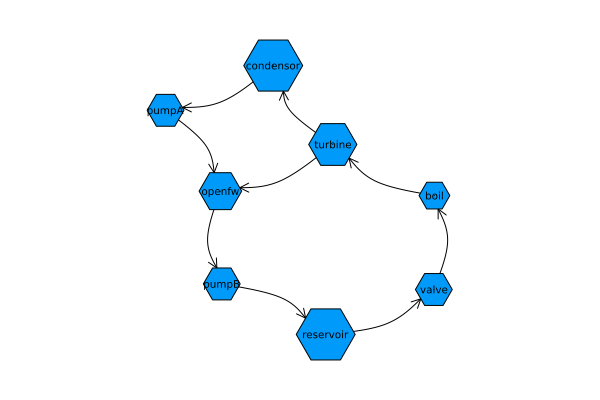

In [69]:
using Graphs, GraphRecipes, Plots
g,cdict,vdict = TSMD.system2graph(ODESYS, verbose = true);
graphplot(g,names = [vdict[i] for i =1:nv(g)])

### Open and Closed FW
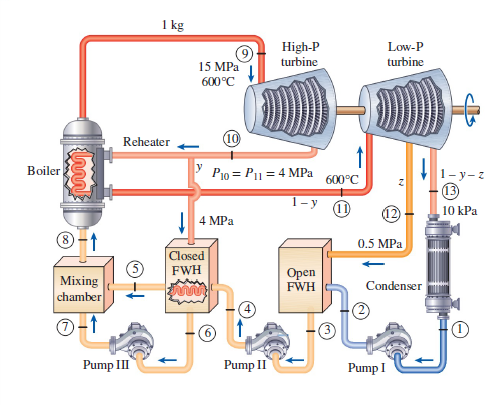

In [2]:
Pmax = 150
Pmid2 = 40
Pmid1 = 5
Pmin = 0.1
Tmax = 600+273.15
@variables t
@named WorkRes     = Steam.WorkPin()
@named ColdUtil    = Steam.HeatTransferPin()
@named HotUtil     = Steam.HeatTransferPin()

@named reservoir    = Steam.ContinuityReservoir()
@named valve        = Steam.SteamFlowSource(ṁ = 1.0)
@named openfw       = Steam.OpenFeedwaterHeater()
@named closedfw     = Steam.ClosedFeedwaterHeater()
@named mixer        = Steam.MixingChamber()

@named pump1        = Steam.AdiabaticPump(Pout = Pmid1, setpressure = false, η=1.0)
@named pump2        = Steam.AdiabaticPump(Pout = Pmax, setpressure = false, η=1.0)
@named pump3        = Steam.AdiabaticPump(Pout = Pmax, setpressure = true, η=1.0, controlinlet = true)

@named turbine1    = Steam.AdiabaticTurbine(setpressure = true, Pout = Pmid2)
@named turbine2    = Steam.SIMOAdiabaticTurbine(setpressure = true, Pyin = Pmid1, Pzin = Pmin, ηin = 1.0) 

@named boiler       = Steam.IdealBoiler(Tout = Tmax)
@named reheat       = Steam.IdealBoiler(Tout = Tmax)
@named condensor    = Steam.IdealCondensor()


connections = vcat(Steam.hydro_connect(reservoir.n,valve.p),
                    Steam.hydro_connect(valve.n, boiler.p),
                    Steam.hydro_connect(boiler.n, turbine1.p),
                    Steam.hydro_connect(turbine1.n, reheat.p, closedfw.p1),
                    Steam.hydro_connect(reheat.n, turbine2.p),
                    Steam.hydro_connect(turbine2.hp.n, openfw.p1),
                    Steam.hydro_connect(turbine2.lp.n, condensor.p),
                    Steam.hydro_connect(condensor.n, pump1.p),
                    Steam.hydro_connect(pump1.n,openfw.p2),
                    Steam.hydro_connect(openfw.n,pump2.p),
                    Steam.hydro_connect(pump2.n,closedfw.p2),
                    Steam.hydro_connect(closedfw.n1,pump3.p),
                    Steam.hydro_connect(pump3.n, mixer.p1),
                    Steam.hydro_connect(closedfw.n2, mixer.p2),
                    Steam.hydro_connect(mixer.n, reservoir.p),
                    TSMD.work_connect(WorkRes, turbine1.w, pump1.w, pump2.w, pump3.w,turbine2.hp.w, turbine2.lp.w),
                    TSMD.heat_connect(ColdUtil, condensor.q),
                    TSMD.heat_connect(HotUtil, boiler.q, reheat.q));
         

systems = [reservoir, valve, openfw, closedfw, mixer, pump1, pump2,pump3,turbine1,turbine2, boiler,reheat,condensor, WorkRes,HotUtil,ColdUtil]
@named odesystem = ODESystem(connections, t; systems = systems)
TSMD.system_details(odesystem)


************ SYSTEM: odesystem ************
SYSTEM: odesystem 


	 # of equations = 299


	 # of states = 299


	 # of parameters = 18
After Alias Elemination:


	 # of equations = 188
	 # of states = 188
	 # of parameters = 18


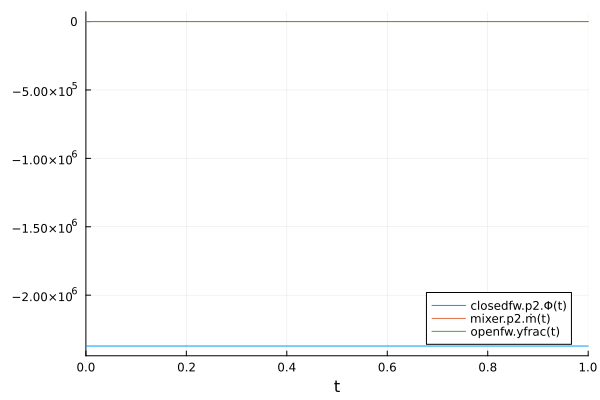

In [4]:
defaults = [valve.Ṁ => 1.0,
        pump1.η => 1.0,
        pump1.P => Pmid2,
        pump2.η => 1.0,
        pump2.P => Pmax,
        pump3.η => 1.0,
        pump3.P => Pmax,
        turbine1.P => Pmid2,
        turbine1.η => 1.0,
        turbine2.Py => Pmid1,
        turbine2.Pz => Pmin,
        turbine2.η => 1.0,
        turbine2.hp.P => Pmid1,
        turbine2.hp.η => 1.0,
        turbine2.lp.P => Pmin,
        turbine2.lp.η => 1.0,
        boiler.T => Tmax,
        reheat.T => Tmax]
simple_sys = structural_simplify(odesystem)
tspan = (0.0,1.0)
ode_prob = ODEProblem(simple_sys,[],tspan,defaults)
sol = solve(ode_prob, Rodas4())
plot(sol)

In [395]:
using Graphs, GraphRecipes, Plots,  NetworkLayout
G,cdict,vdict = TSMD.system2graph(odesystem, verbose = false);
TSMD.add_graph_connection!(odesystem,G,cdict,vdict, WorkRes.Ẇ)
TSMD.add_graph_connection!(odesystem,G,cdict,vdict, HotUtil.Q̇)
TSMD.add_graph_connection!(odesystem,G,cdict,vdict, ColdUtil.Q̇)
@show collect(keys(vdict))
display(cdict)
display(vdict)

Dict{Symbol, Int64} with 16 entries:
  :pump3     => 12
  :condensor => 9
  :WorkRes   => 14
  :openfw    => 8
  :pump2     => 11
  :closedfw  => 5
  :valve     => 2
  :pump1     => 10
  :turbine1  => 4
  :boiler    => 3
  :reheat    => 6
  :turbine2  => 7
  :ColdUtil  => 16
  :HotUtil   => 15
  :mixer     => 13
  :reservoir => 1

Dict{Int64, Symbol} with 16 entries:
  5  => :closedfw
  16 => :ColdUtil
  7  => :turbine2
  12 => :pump3
  8  => :openfw
  1  => :reservoir
  4  => :turbine1
  6  => :reheat
  13 => :mixer
  2  => :valve
  10 => :pump1
  11 => :pump2
  9  => :condensor
  15 => :HotUtil
  14 => :WorkRes
  3  => :boiler

Warning - may incorrectly create graph @ src = ["turbine2", "turbine2"] to dst = ["turbine2"]
collect(keys(vdict)) = [5, 16, 7, 12, 8, 1, 4, 6, 13, 2, 10, 11, 9, 15, 14, 3]


vdict[cdict[i]] = :HotUtil
vdict[cdict[i]] = :ColdUtil
vdict[cdict[i]] = :WorkRes


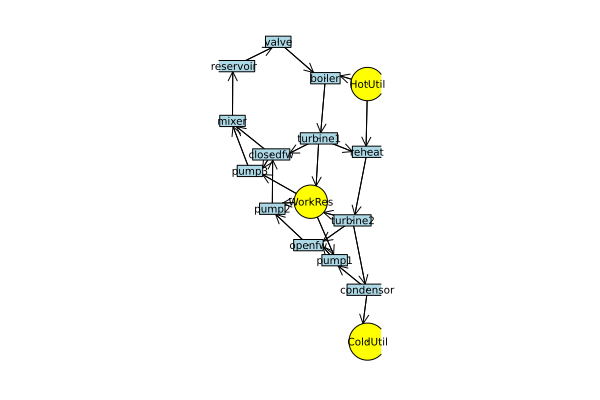

In [442]:
topin = [:HotUtil, :ColdUtil, :WorkRes]
locs = [(0.0,1.0), (0.0,-1.0), (0.0,0.0)]
pin_dict = Dict(cdict[topin[i]] => locs[i] for i = 1:2)

nshape = Dict(i => :rect for i = 1:nv(G))
colo = Dict(i => :lightblue for i =1:nv(G))

for i in topin
    nshape[cdict[i]] = :circle
    colo[cdict[i]] = :yellow
    @show vdict[cdict[i]]
end
# inipos = squaregrid(adjacency_matrix(G); Ptype = Float64, cols = :auto, skip = collect(keys(pin_dict)))
inipos = spring(adjacency_matrix(G); seed = 2,  C =0.5, Ptype = Float64, pin = pin_dict);#(adjacency_matrix(G))
pos_x = [p[1] for p in inipos]
pos_y = [p[2] for p in inipos]

graphplot(G, names = [vdict[i] for i = 1:nv(G)], 
                x = pos_x, y = pos_y,
                nodesize = 0.2,
                curves = false,
                axis_buffer = 0.1,
                nodeshape = [nshape[i] for i =1:nv(G)],
                nodecolor = [colo[i] for i =1:nv(G)],
                ticks = :auto)

# graphplot(G, names = [vdict[i] for i = 1:nv(G)], 
#                 size = (600,600),
#                 curves = false,
#                 x = pos_x, y = pos_y,
#                 nodesize = 0.5,
#                 axis_buffer = 0.1,
#                 nodeshape = :rect,
#                 nodecolor = range(colorant"lightblue", stop=colorant"lightblue", length=nv(G)),
#                 ticks = :auto,
#                 grid =  true)

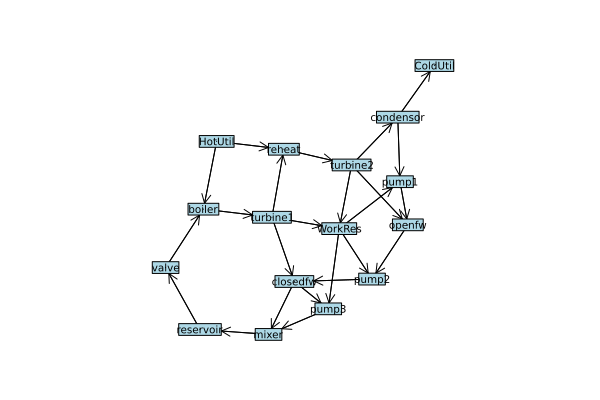

In [299]:
inipos = Spring(Ptype = Float64, C = 2.0, pin = pin_dict)(adjacency_matrix(G))


# inipos = (adjacency_matrix(G); Ptype = Float64, cols = :auto)
pos_x = [p[1] for p in inipos]
pos_y = [p[2] for p in inipos]

graphplot(G, names = [vdict[i] for i = 1:nv(G)], curves = false,
                method = :spfd,
                layout_kw = [:K => 1.0, :pin => pin_dict],
                curvature = false,
                nodesize = .1,
                nodeshape = :rect,
                nodecolor = :lightblue)

In [253]:

# # layout = Spring(Ptype = Float64, C = 2.0)(adjacency_matrix(G))
# inipos = squaregrid(adjacency_matrix(G); Ptype = Float64, cols = :auto)
# pos_x = [p[1] for p in inipos]
# pos_y = [p[2] for p in inipos]
# @show pos_x
# finalpos = stress(adjacency_matrix(G); Ptype = Float64, initialpos = inipos) #(adjacency_matrix(G))
# fpos_x = [round(p[1])*2 for p in finalpos]
# fpos_y = [round(p[2]) for p in finalpos]

# # @show fpos_y
# plot(
#     graphplot(G, names = [vdict[i] for i = 1:nv(G)],
#                 x = pos_x, y = pos_y,
#                 curvature = false,
#                 nodesize = .5,
#                 nodeshape = :rect,
#                 nodecolor = :lightblue),
#     graphplot(G, names = [vdict[i] for i = 1:nv(G)],
#                 x = fpos_x, y = fpos_y,
#                 curvature = false,
#                 nodesize = .75,
#                 nodeshape = :rect,
#                 nodecolor = :lightblue)
# )


pos_x = [0.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0, 3.0, 0.0, 1.0]


KeyError: KeyError: key 14 not found

13-element Vector{Float32}:
 -0.107277334
 -2.133556
 -0.9296014
  1.1781058
  0.45116997
 -0.7748282
 -0.5526597
  0.4706483
 -2.0424387
 -0.50567406
  0.84502447
  0.44599476
 -0.22924599